# 08. Force Matching 

## Building the model graph

In [1]:
import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Build the graph
NN = 63
graph = htf.graph_builder(NN, output_forces=False)
# make trainable variables
epsilon = tf.Variable(0.9, name='lj-epsilon', trainable=True)
sigma = tf.Variable(1.1, name='lj-sigma', trainable=True)
# get LJ potential using our variables
# uses built in nlist_rinv which provides
# r^-1 with each neighbor
inv_r6 = sigma**6 * graph.nlist_rinv**6
# use 2 * epsilon because nlist is double-counted
p_energy = 2.0 * epsilon * (inv_r6**2 - inv_r6)
# sum over pairs to get total energy
energy = tf.reduce_sum(p_energy, axis=1, name='energy')
# compute forces
computed_forces = graph.compute_forces(energy)
# compare hoomd-blue forces (graph.forces) with our 
# computed forces
minimizer, loss = htf.force_matching(graph.forces[:,:3], 
                                     computed_forces[:,:3],
                                     learning_rate=1e-2)
# save loss so we can visualize later
graph.save_tensor(loss, 'cost')
# Make sure to have minimizer in out_nodes so that the force matching occurs!
graph.save(model_directory='CG_tutorial/force_matching',
           out_nodes=[minimizer])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Note: Backed-up CG_tutorial/force_matching previous model to CG_tutorial/force_matching/previous_model_1



## Running the simulation

In [3]:
# run the simulation
model_dir = 'CG_tutorial/force_matching'
hoomd.context.initialize('--mode=cpu')
with hoomd.htf.tfcompute(model_dir) as tfcompute:
    rcut = 7.5
    system = hoomd.init.create_lattice(
        unitcell=hoomd.lattice.sq(a=4.0),
        n=[4,4])
    nlist = hoomd.md.nlist.cell(check_period=1)
    lj = hoomd.md.pair.lj(r_cut=rcut, nlist=nlist)
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.005)
    hoomd.md.integrate.nve(group=hoomd.group.all(
            )).randomize_velocities(kT=2, seed=2)
    tfcompute.attach(nlist, r_cut=rcut, save_period=10)
    hoomd.run(1e3)

HOOMD-blue v2.5.2 CUDA (10.0) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 03/19/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 16 particles
notice(2): Force mode is FORCE_MODE.hoomd2tf 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate

INFO:tensorflow:The following quantities will computed:
INFO:tensorflow:	name period batch

INFO:tensorflow:	 Adam 1 N

## Loading the trained variables and cost

In [4]:
time = np.arange(0, 1e3, 10)
cost = np.empty(len(time))
epsilon = np.empty(len(time))
sigma = np.empty(len(time))
for i, t in enumerate(time):
    variables = hoomd.htf.load_variables(model_dir, names = ['cost', 'lj-epsilon', 'lj-sigma'], checkpoint = int(t))
    cost[i] = variables['cost']
    epsilon[i] = variables['lj-epsilon']
    sigma[i] = variables['lj-sigma']

INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-0
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-10
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-20
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-30
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-40
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-50
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-60
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-70
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-80
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-90
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-100
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-110
INFO:tensorflow:Restoring parameters from CG_tutorial/force_mat

## Plotting training progress

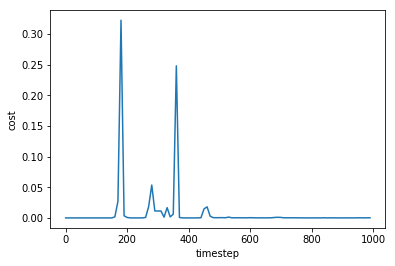

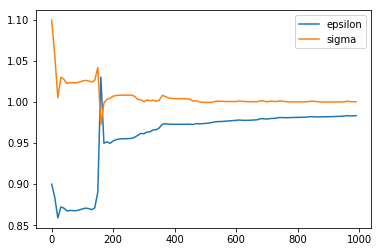

In [5]:
plt.figure()
plt.plot(time, cost) #, label = 'cost')
plt.xlabel('timestep')
plt.ylabel('cost')
plt.show()

plt.figure()
plt.plot(time, epsilon, label = 'epsilon')
plt.plot(time, sigma, label = 'sigma')
plt.legend()
plt.show()

## Plotting the potential

In [6]:
r = np.linspace(0.2, 4, 1000)
start_pot = hoomd.htf.compute_pairwise_potential(model_dir, r, 'energy', checkpoint=0)
end_pot = hoomd.htf.compute_pairwise_potential(model_dir, r, 'energy', checkpoint=-1)
true_pot = 2 * (r**-12 - r**-6)

INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-0
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-999


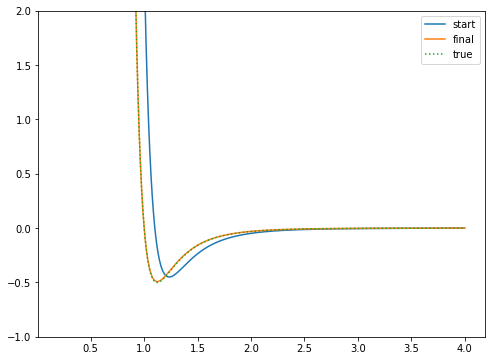

In [7]:
plt.figure(figsize=(8,6))
plt.plot(r, start_pot[0], label='start')
plt.plot(r, end_pot[0], label='final')
plt.plot(r, true_pot, label='true', linestyle=':')
plt.legend()
plt.ylim(-1,2)
plt.show()